In [1]:
!pip -q install pandas numpy scikit-learn xgboost scipy seaborn matplotlib prince


In [2]:
import os, sys, json, time, inspect, warnings

import numpy as np
import pandas as pd
from scipy import sparse, stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif

import xgboost as xgb
import sklearn

In [4]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
print(f"\nTrain shape: {train.shape} | Test shape: {test.shape}")


Train shape: (15533, 18) | Test shape: (5225, 17)


In [5]:
TARGET   = "WeightCategory"
CAT_COLS = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
NUM_COLS = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']

In [6]:
for df in (train, test):
    df["BMI"]  = df["Weight"] / (df["Height"]**2)
    df["BMI2"] = df["BMI"]**2
    df["Age2"] = df["Age"]**2

NUM_COLS_EXT = NUM_COLS + ["BMI","BMI2","Age2"]

X = train[CAT_COLS + NUM_COLS_EXT]
y = train[TARGET]
X_test = test[CAT_COLS + NUM_COLS_EXT]

display(train.head(5))
print(train.dtypes)
print(train.isnull().sum())
print(test.isnull().sum())

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory,BMI,BMI2,Age2
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,...,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,798.603001,597.460787
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,...,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,548.594334,324.000000
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,...,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,293.324052,324.000000
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,...,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,2012.042650,439.017188
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,...,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,655.316531,1001.158007


id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
WeightCategory                     object
BMI                               float64
BMI2                              float64
Age2                              float64
dtype: object
id                                0
Gender                            0
Age                             

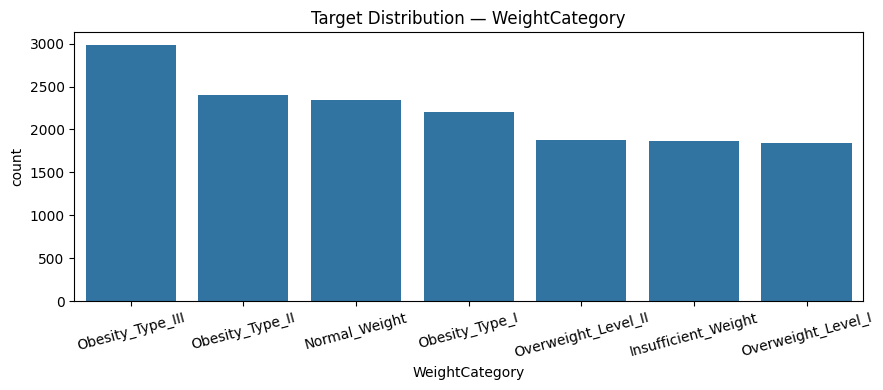

In [ ]:
plt.figure(figsize=(9,4))
order = train[TARGET].value_counts().index
sns.countplot(data=train, x=TARGET, order=order)
plt.title("Target Distribution — WeightCategory")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [9]:
print("\nNumeric Summary — overall:")
display(train[NUM_COLS + ["BMI","BMI2","Age2"]].describe().T)

print("\nNumeric Summary by class (mean ± std):")
grouped = train.groupby(TARGET)[NUM_COLS + ["BMI","BMI2","Age2"]].agg(['mean','std','median'])
display(grouped)


Numeric Summary — overall:


,count,mean,std,min,25%,50%,75%,max
Age,15533.0,23.816308,5.663167,14.000000,20.000000,22.771612,26.000000,61.000000
Height,15533.0,1.699918,0.087670,1.450000,1.630927,1.700000,1.762921,1.975663
Weight,15533.0,87.785225,26.369144,39.000000,66.000000,84.000000,111.600553,165.057269
FCVC,15533.0,2.442917,0.530895,1.000000,2.000000,2.342220,3.000000,3.000000
NCP,15533.0,2.760425,0.706463,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,15533.0,2.027626,0.607733,1.000000,1.796257,2.000000,2.531456,3.000000
FAF,15533.0,0.976968,0.836841,0.000000,0.007050,1.000000,1.582675,3.000000
TUE,15533.0,0.613813,0.602223,0.000000,0.000000,0.566353,1.000000,2.000000
BMI,15533.0,30.214076,8.314810,12.868541,24.088223,29.384757,36.962959,54.997991
BMI2,15533.0,982.022003,511.937428,165.599340,580.242493,863.463924,1366.260375,3024.779054



Numeric Summary by class (mean ± std):


Age                         Height            \
                          mean       std     median      mean       std   
WeightCategory                                                            
Insufficient_Weight  19.335698  2.261241  19.000000  1.683396  0.096871   
Normal_Weight        20.848144  3.525865  21.000000  1.669388  0.086777   
Obesity_Type_I       25.060305  7.266122  22.851773  1.693869  0.091527   
Obesity_Type_II      27.665552  4.232434  26.684354  1.782640  0.064126   
Obesity_Type_III     24.094061  2.591641  25.955361  1.676413  0.059231   
Overweight_Level_I   23.080321  5.970375  21.000000  1.686846  0.085629   
Overweight_Level_II  25.875042  7.572139  23.000000  1.705915  0.075110   

                                   Weight                             FCVC  \
                       median        mean        std      median      mean   
WeightCategory                                                               
Insufficient_Weight  1.700000   49.951261   5.879486   50.000000  2.478188   
Normal_Weight        1.660000   61.490360   8.501453   60.000000  2.366842   
Obesity_Type_I       1.694969   92.364532  11.510740   90.500055  2.096296   
Obesity_Type_II      1.773521  116.140424   7.728839  118.377601  2.433039   
Obesity_Type_III     1.643786  117.861193  13.443202  111.919155  3.000000   
Overweight_Level_I   1.700000   74.307331   7.958609   75.000000  2.264248   
Overweight_Level_II  1.700000   82.098633   7.434170   81.322970  2.213706   

                     ...       TUE        BMI                       \
                     ...    median       mean       std     median   
WeightCategory       ...                                             
Insufficient_Weight  ...  1.000000  17.620807  1.436097  17.532467   
Normal_Weight        ...  1.000000  22.022789  2.199240  22.038567   
Obesity_Type_I       ...  0.669616  32.140990  2.563158  32.079969   
Obesity_Type_II      ...  0.080128  36.571814  2.114441  36.390629   
Obesity_Type_III     ...  0.561661  41.817001  2.690302  41.770084   
Overweight_Level_I   ...  0.105895  26.091838  1.800208  25.981978   
Overweight_Level_II  ...  0.894678  28.203188  1.797373  28.055706   

                            BMI2                                 Age2  \
                            mean         std       median        mean   
WeightCategory                                                          
Insufficient_Weight   312.554108   57.872717   307.387401  378.979697   
Normal_Weight         489.837814   97.075931   485.698457  447.071544   
Obesity_Type_I       1039.610013  167.091122  1029.124437  680.791473   
Obesity_Type_II      1341.966579  153.269011  1324.277857  783.288789   
Obesity_Type_III     1755.896874  223.773896  1744.739896  587.238106   
Overweight_Level_I    684.023014   93.770316   675.063210  568.327246   
Overweight_Level_II   798.648649  104.256886   787.122627  726.824593   

                                             
                            std      median  
WeightCategory                               
Insufficient_Weight  103.343455  361.000000  
Normal_Weight        178.875253  441.000000  
Obesity_Type_I       433.858513  522.203529  
Obesity_Type_II      251.336091  712.054748  
Obesity_Type_III     119.054192  673.680765  
Overweight_Level_I   357.513231  441.000000  
Overweight_Level_II  477.306503  529.000000  

[7 rows x 33 columns]

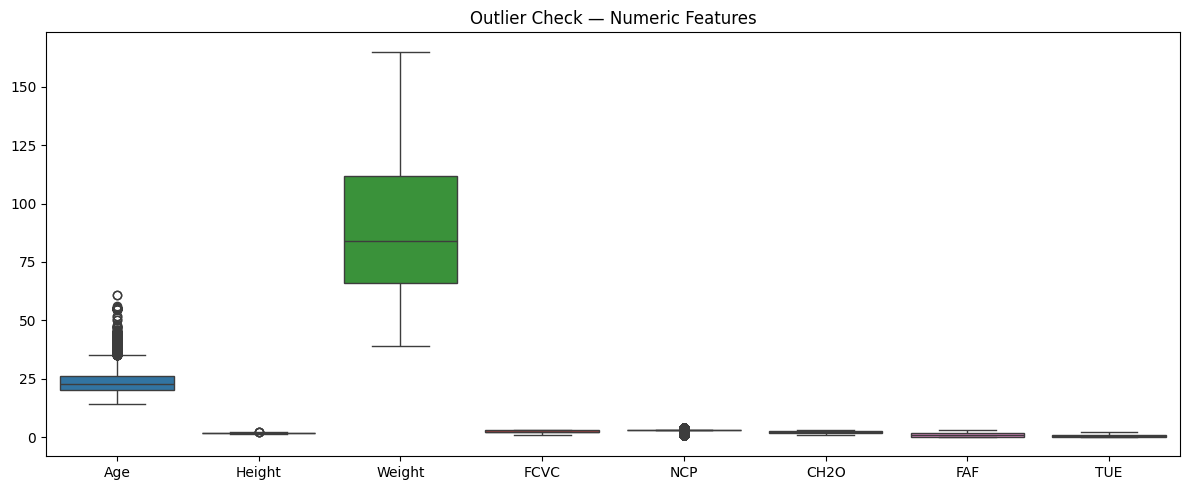

In [10]:
plt.figure(figsize=(12,5))
sns.boxplot(data=train[NUM_COLS])
plt.title("Outlier Check — Numeric Features")
plt.tight_layout()
plt.show()

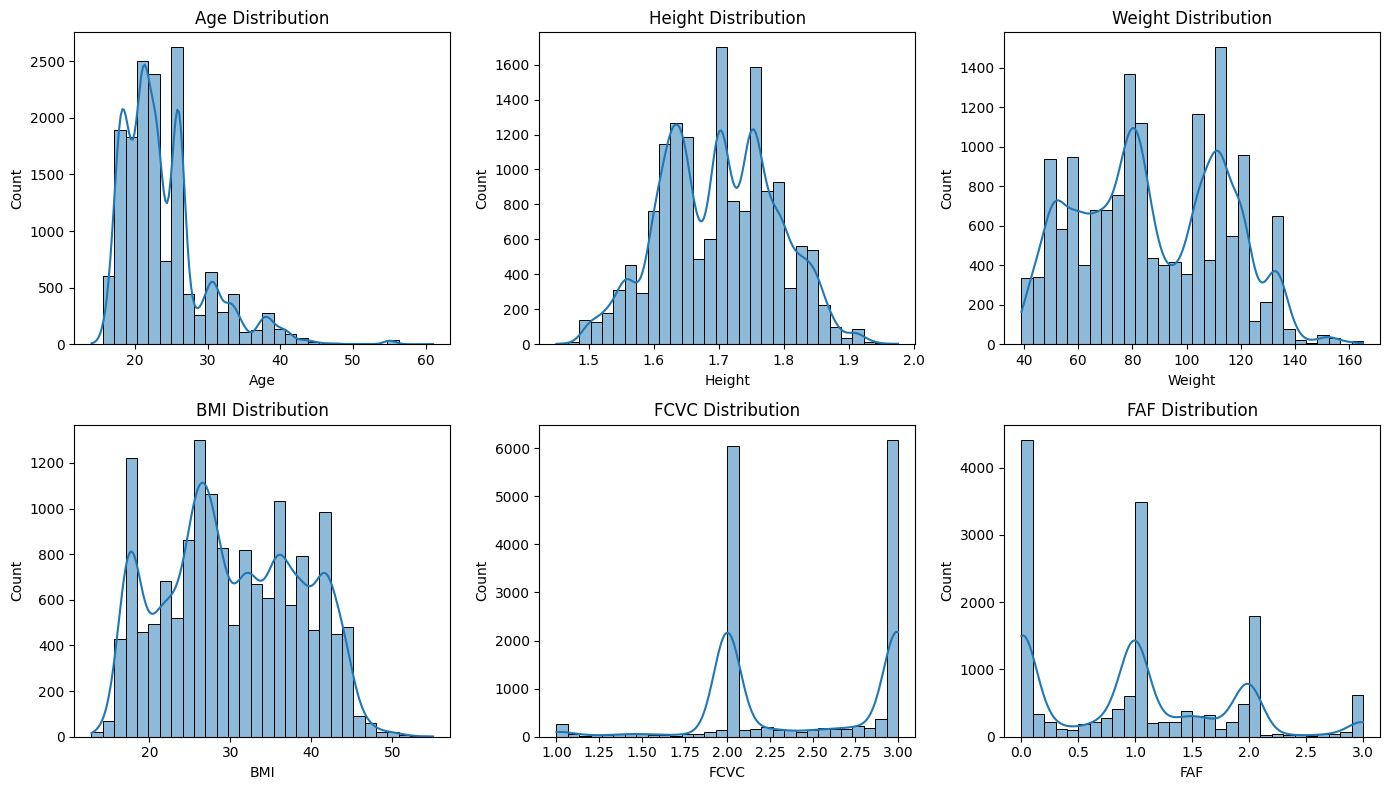

In [11]:

fig, axes = plt.subplots(2,3, figsize=(14,8))
for ax, col in zip(axes.ravel(), ['Age','Height','Weight','BMI','FCVC','FAF']):
    sns.histplot(train[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"{col} Distribution")
plt.tight_layout(); plt.show()

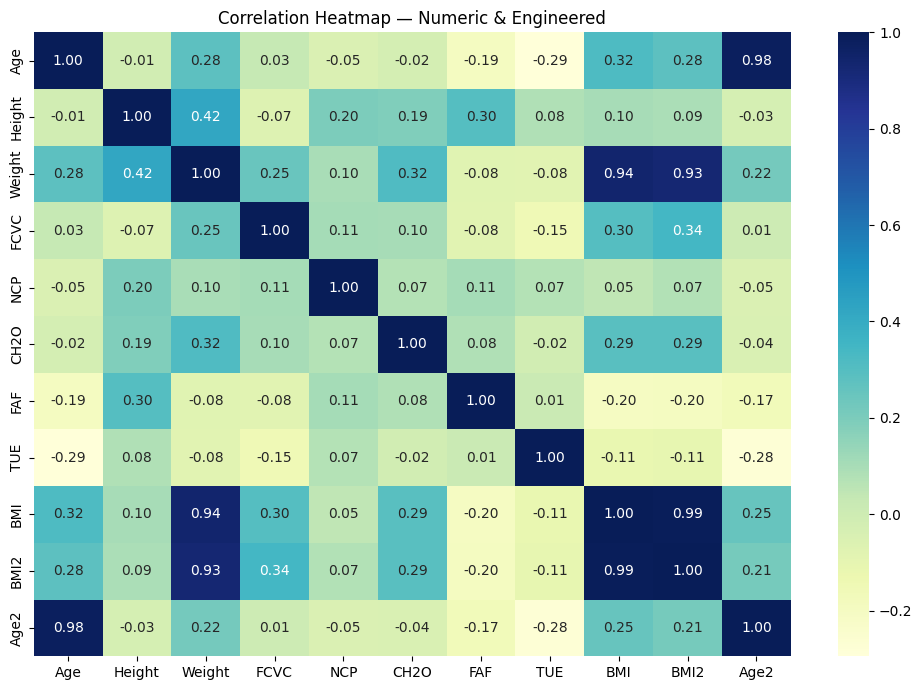

In [12]:
corr_cols = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','BMI','BMI2','Age2']
plt.figure(figsize=(10,7))
sns.heatmap(train[corr_cols].corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Heatmap — Numeric & Engineered")
plt.tight_layout(); plt.show()


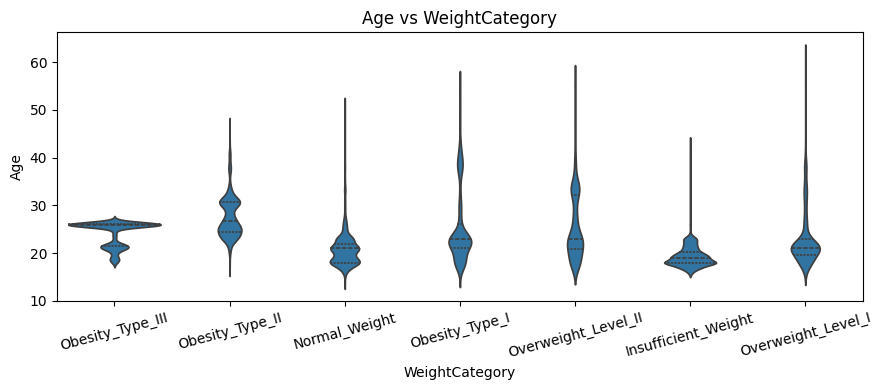

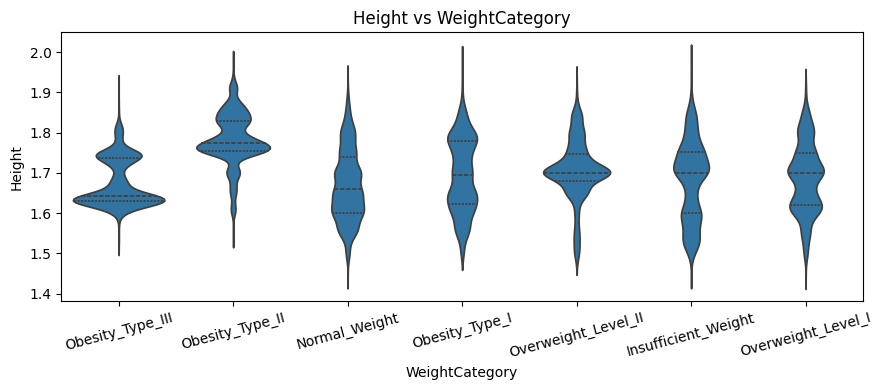

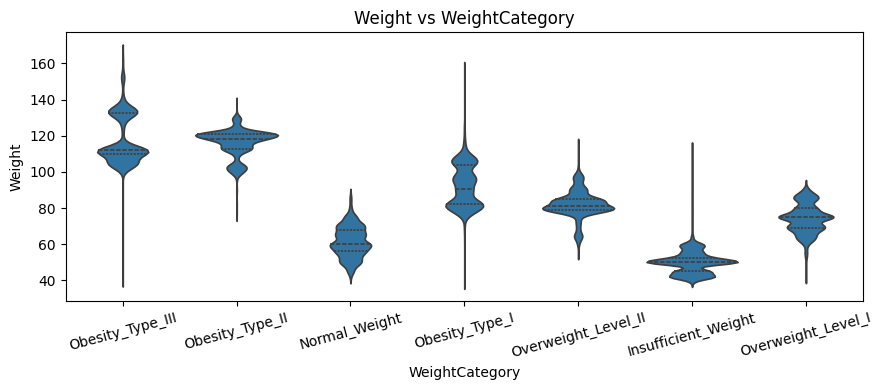

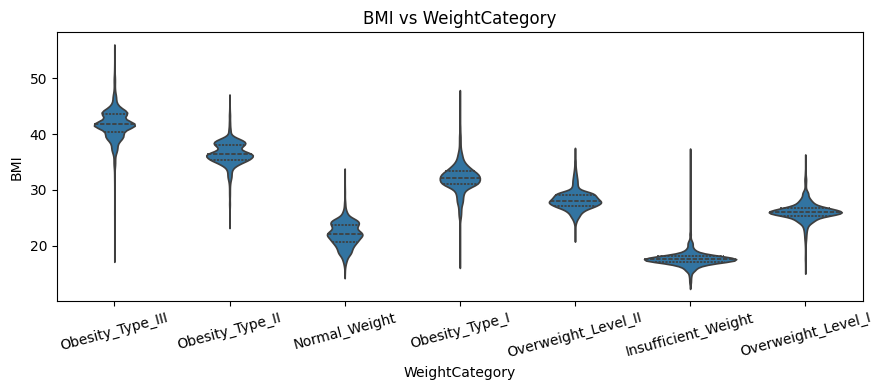

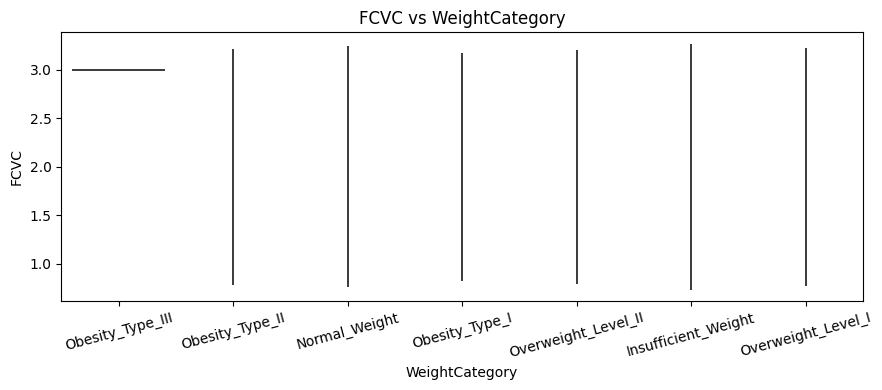

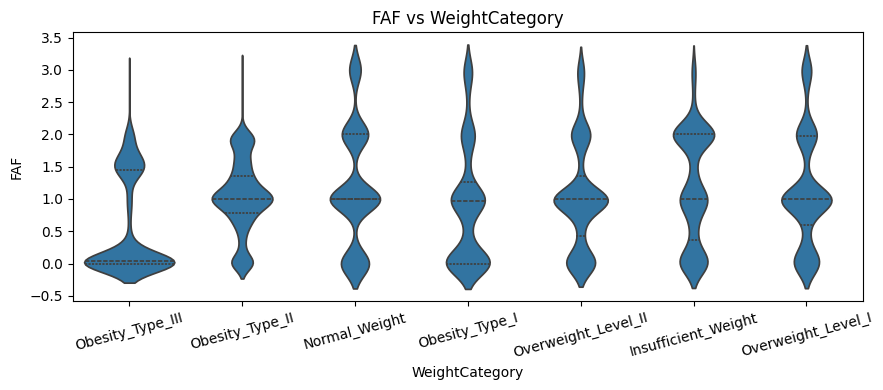

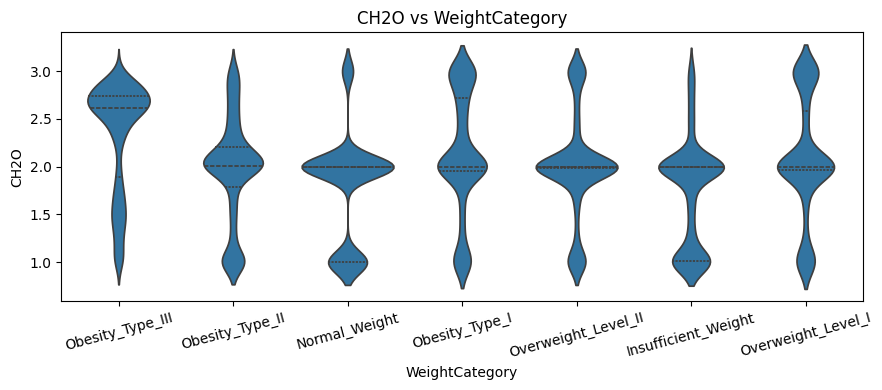

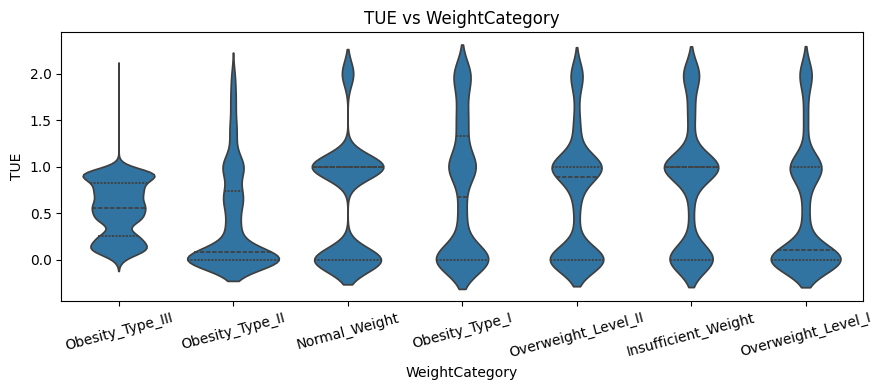

In [13]:
for col in ['Age','Height','Weight','BMI','FCVC','FAF','CH2O','TUE']:
    plt.figure(figsize=(9,4))
    sns.violinplot(data=train, x=TARGET, y=col, order=order, inner="quartile")
    plt.title(f"{col} vs WeightCategory")
    plt.xticks(rotation=15)
    plt.tight_layout(); plt.show()



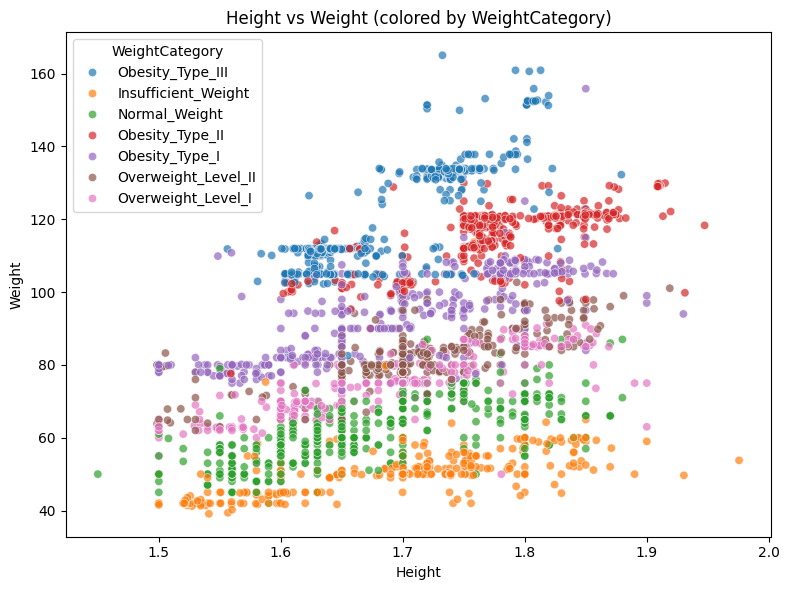

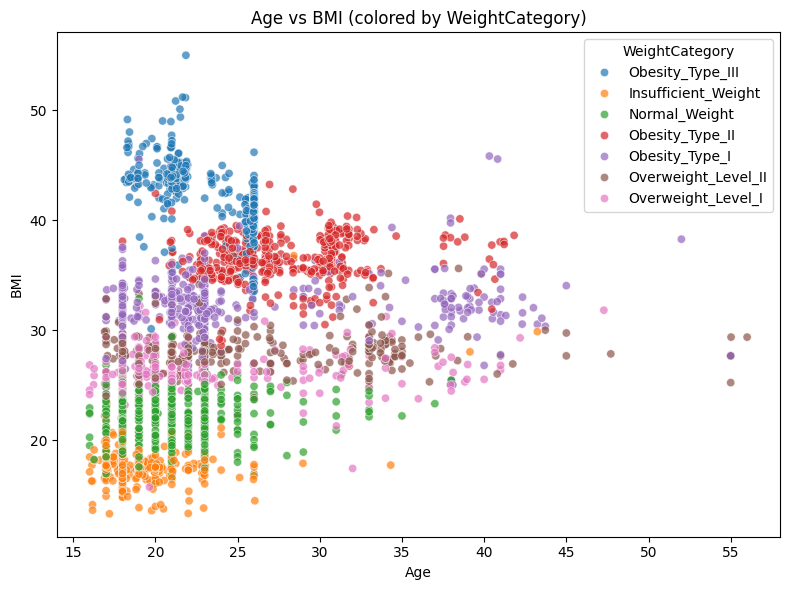

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train.sample(min(3000, len(train)), random_state=42),
                x='Height', y='Weight', hue=TARGET, palette='tab10', alpha=0.7)
plt.title("Height vs Weight (colored by WeightCategory)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=train.sample(min(3000, len(train)), random_state=42),
                x='Age', y='BMI', hue=TARGET, palette='tab10', alpha=0.7)
plt.title("Age vs BMI (colored by WeightCategory)")
plt.tight_layout(); plt.show()


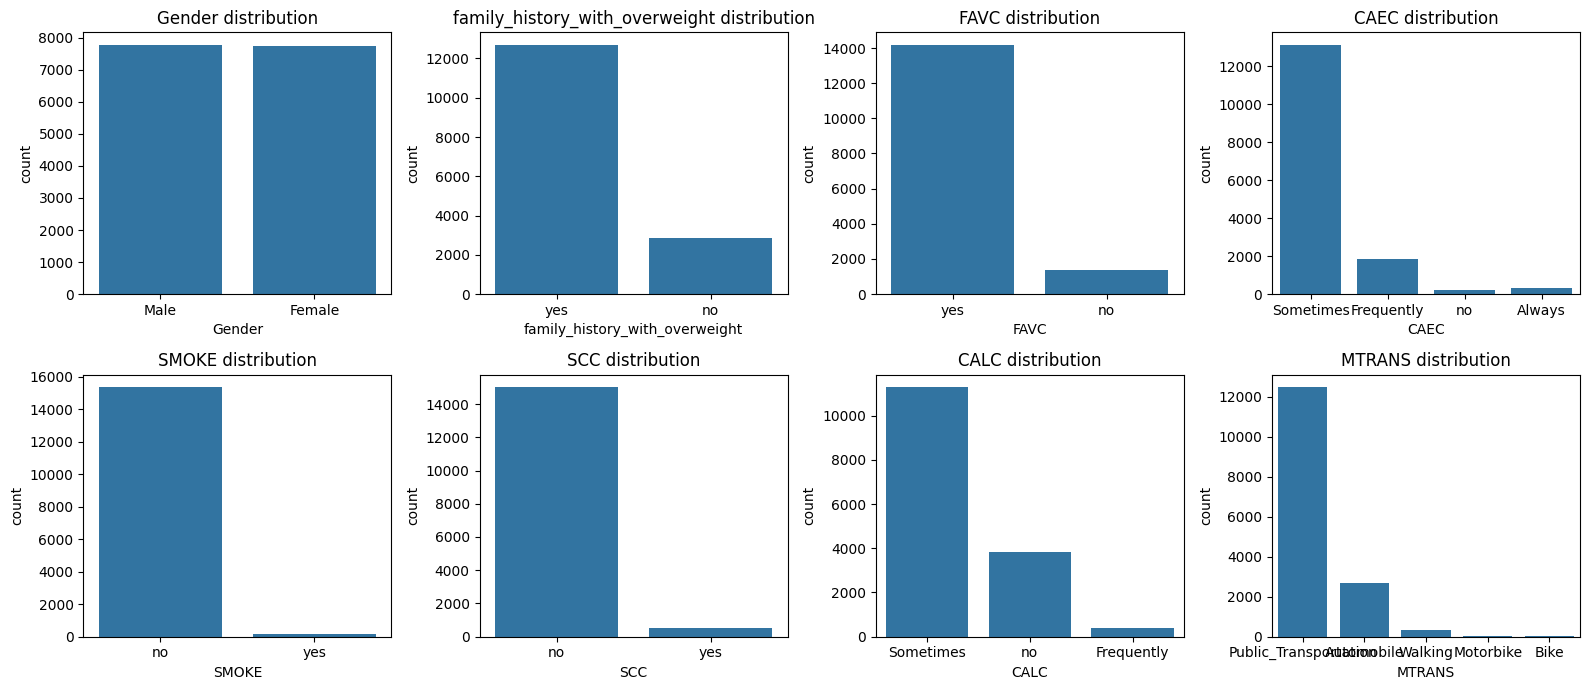

In [15]:
fig, axes = plt.subplots(2,4, figsize=(16,7))
for ax, col in zip(axes.ravel(), CAT_COLS):
    sns.countplot(data=train, x=col, ax=ax)
    ax.set_title(f"{col} distribution")
    ax.tick_params(axis='x', rotation=0)
plt.tight_layout(); plt.show()

In [16]:
def plot_normalized_stacked_bars(df, cat_col, target_col):
    ct = pd.crosstab(df[cat_col], df[target_col], normalize='index') * 100.0
    ct = ct[order]
    ct.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f"{cat_col} vs {target_col} — % within {cat_col}")
    plt.ylabel("%")
    plt.legend(title=target_col, bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout(); plt.show()

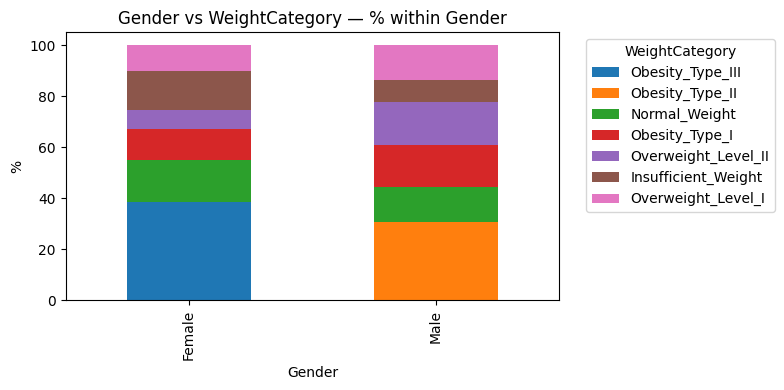

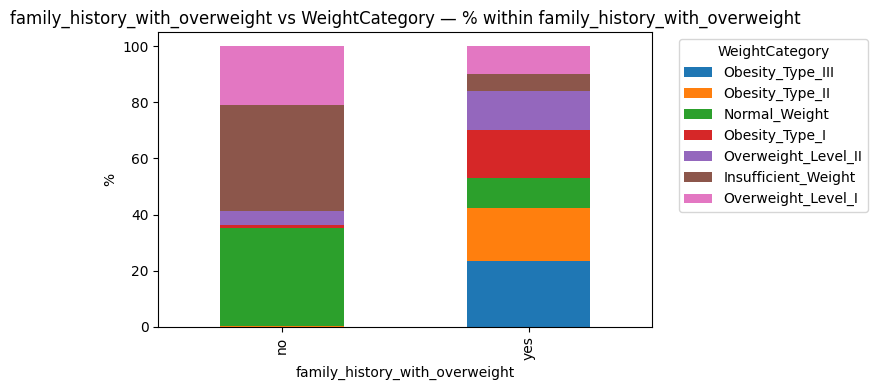

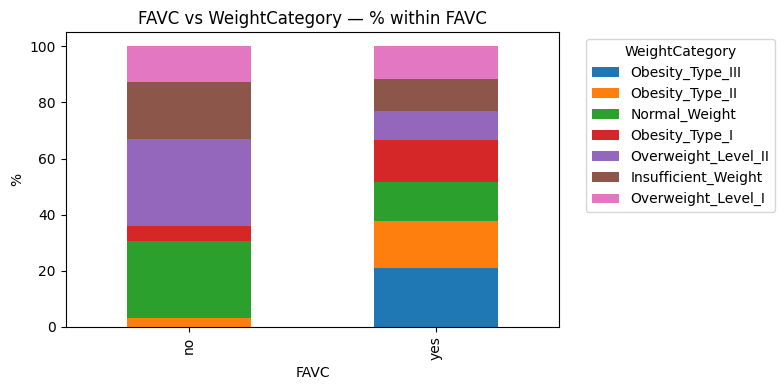

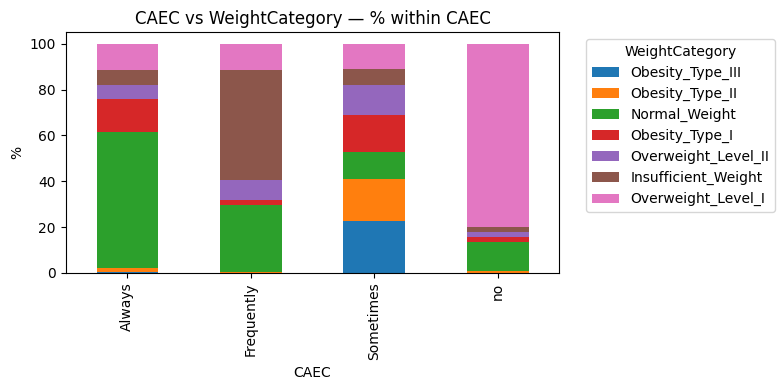

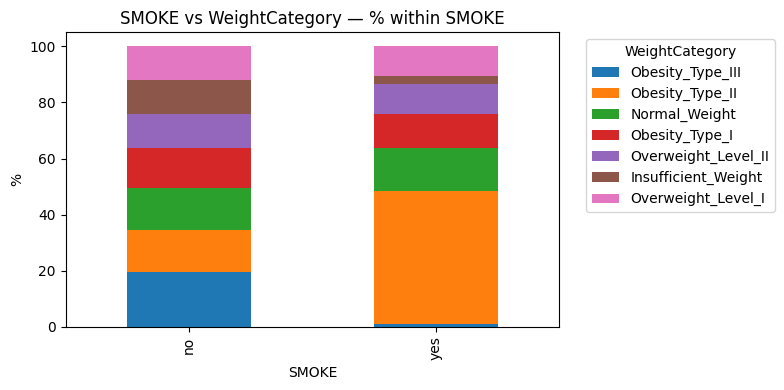

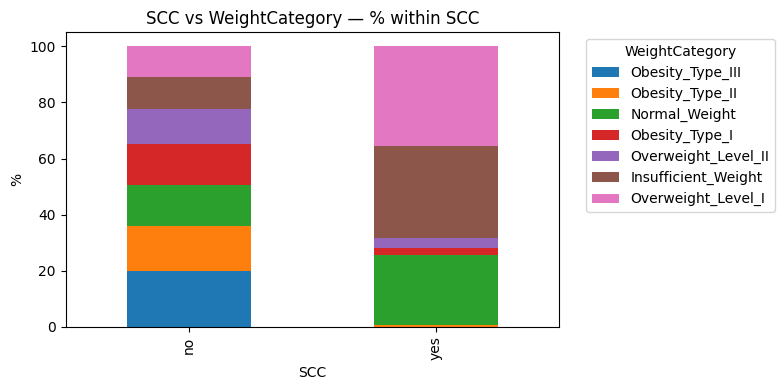

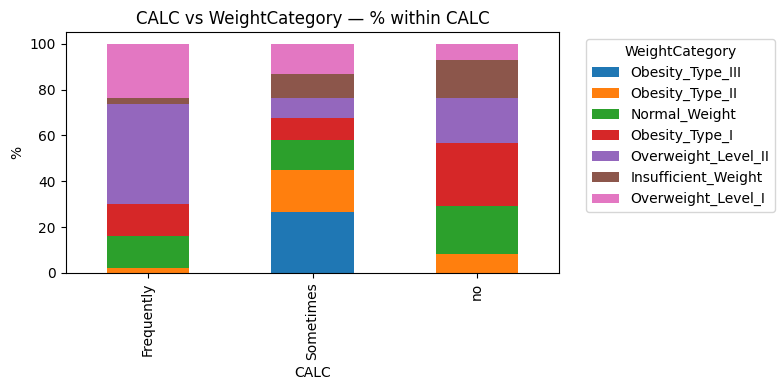

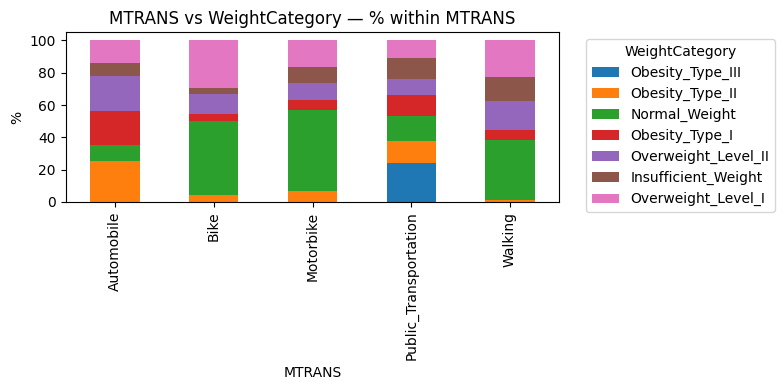

In [17]:
for col in CAT_COLS:
    plot_normalized_stacked_bars(train, col, TARGET)

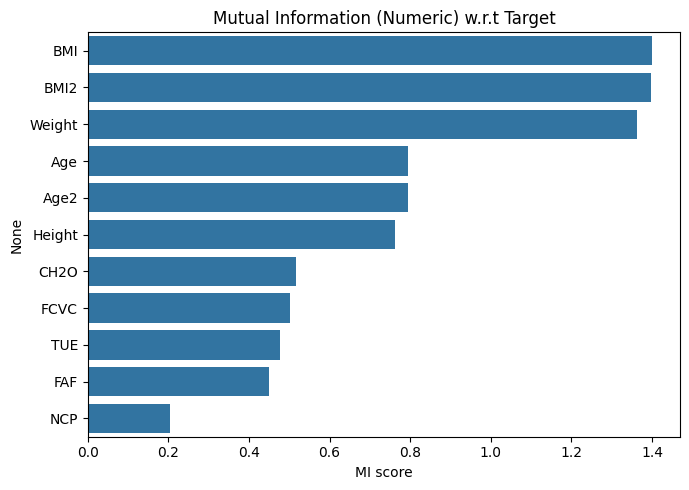

In [18]:
y_codes = train[TARGET].astype('category').cat.codes
mi_num = mutual_info_classif(train[NUM_COLS + ["BMI","BMI2","Age2"]], y_codes, discrete_features=False, random_state=42)
mi_num_ser = pd.Series(mi_num, index=NUM_COLS + ["BMI","BMI2","Age2"]).sort_values(ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=mi_num_ser.values, y=mi_num_ser.index)
plt.title("Mutual Information (Numeric) w.r.t Target")
plt.xlabel("MI score"); plt.tight_layout(); plt.show()

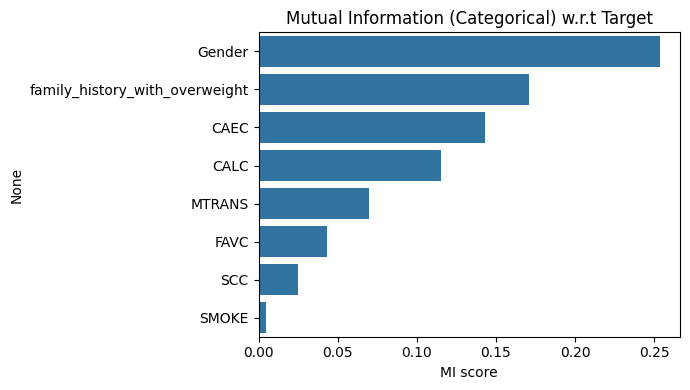

In [19]:
def cat_mi(col):
    return mutual_info_score(train[col], train[TARGET])
mi_cat_ser = pd.Series({c: cat_mi(c) for c in CAT_COLS}).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=mi_cat_ser.values, y=mi_cat_ser.index)
plt.title("Mutual Information (Categorical) w.r.t Target")
plt.xlabel("MI score"); plt.tight_layout(); plt.show()

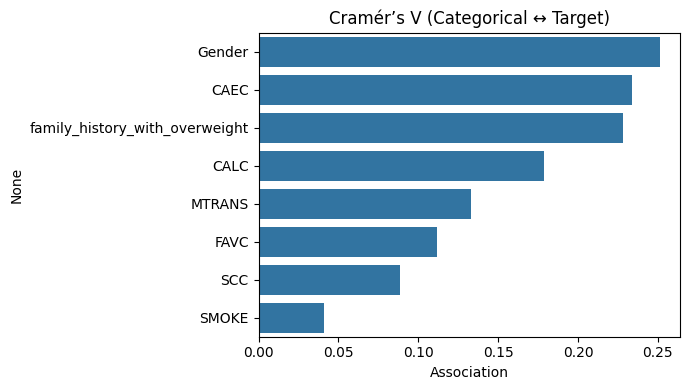

In [20]:
def cramers_v(x, y):
    tab = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(tab, correction=False)[0]
    n = tab.values.sum()
    phi2 = chi2 / n
    r, k = tab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))
cramers_v_scores = pd.Series({c: cramers_v(train[c], train[TARGET]) for c in CAT_COLS}).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=cramers_v_scores.values, y=cramers_v_scores.index)
plt.title("Cramér’s V (Categorical ↔ Target)")
plt.xlabel("Association"); plt.tight_layout(); plt.show()

In [21]:
drift_table = []

for col in NUM_COLS + ["BMI","BMI2","Age2"]:
    ks = stats.ks_2samp(train[col].dropna(), test[col].dropna())
    drift_table.append((col, "numeric", ks.statistic, ks.pvalue))

for col in CAT_COLS:
    tr = train[col].value_counts()
    te = test[col].value_counts()
    align_idx = sorted(set(tr.index) | set(te.index))
    tr = tr.reindex(align_idx, fill_value=0).values
    te = te.reindex(align_idx, fill_value=0).values
    chi2, p, _, _ = stats.chi2_contingency(np.vstack([tr, te]))
    drift_table.append((col, "categorical", chi2, p))
drift_df = pd.DataFrame(drift_table, columns=["feature","type","statistic","p_value"]).sort_values("p_value")
print("\nTrain vs Test drift checks (smaller p = stronger evidence of shift):")
display(drift_df.head(15))


Train vs Test drift checks (smaller p = stronger evidence of shift):


,feature,type,statistic,p_value
7,TUE,numeric,0.019865,0.090153
9,BMI2,numeric,0.019155,0.112021
8,BMI,numeric,0.019155,0.112021
11,Gender,categorical,2.374549,0.123327
3,FCVC,numeric,0.018792,0.124780
2,Weight,numeric,0.018254,0.145847
12,family_history_with_overweight,categorical,2.107640,0.146565
6,FAF,numeric,0.017929,0.159903
13,FAVC,categorical,1.247839,0.263966
5,CH2O,numeric,0.015946,0.270253


/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/naitikbhavsar/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encounter

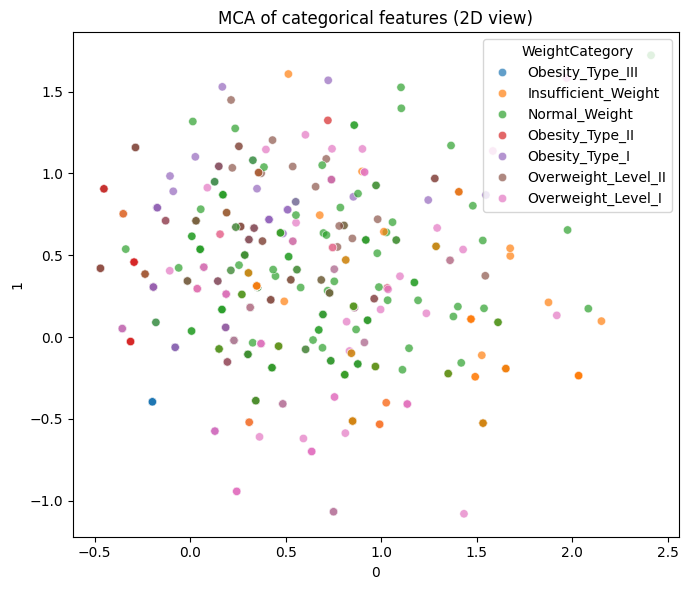

In [23]:
import prince

samp = train.sample(min(3000, len(train)), random_state=42)
mca = prince.MCA(n_components=2, random_state=42)
mca_fit = mca.fit(samp[CAT_COLS])
coords = mca_fit.transform(samp[CAT_COLS])
plt.figure(figsize=(7,6))
sns.scatterplot(x=coords[0], y=coords[1], hue=samp[TARGET], palette='tab10', alpha=0.7)
plt.title("MCA of categorical features (2D view)")
plt.tight_layout(); plt.show()

In [24]:
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
    ohe_kwargs["sparse_output"] = True
else:
    ohe_kwargs["sparse"] = True

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(**ohe_kwargs), CAT_COLS),
        ("num", "passthrough", NUM_COLS_EXT),
    ],
    remainder="drop"
)

In [25]:
def run_cv_xgb(xgb_params, n_splits=5, num_boost_round=4500, early_stopping=120, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    classes     = np.unique(y)
    class_to_ix = {c: i for i, c in enumerate(classes)}
    y_idx       = np.array([class_to_ix[v] for v in y], dtype=np.int32)
    K           = len(classes)

    oof_prob  = np.zeros((len(X), K), dtype=np.float32)
    test_prob = np.zeros((len(X_test), K), dtype=np.float32)
    fold_accs = []

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr_idx    = y_idx[trn_idx]
        y_val_idx   = y_idx[val_idx]

        X_tr_enc  = pre.fit_transform(X_tr, y.iloc[trn_idx])
        X_val_enc = pre.transform(X_val)
        X_tst_enc = pre.transform(X_test)

        if not sparse.issparse(X_tr_enc):  X_tr_enc  = sparse.csr_matrix(X_tr_enc)
        if not sparse.issparse(X_val_enc): X_val_enc = sparse.csr_matrix(X_val_enc)
        if not sparse.issparse(X_tst_enc): X_tst_enc = sparse.csr_matrix(X_tst_enc)

        dtrain = xgb.DMatrix(X_tr_enc,  label=y_tr_idx)
        dvalid = xgb.DMatrix(X_val_enc, label=y_val_idx)
        dtest  = xgb.DMatrix(X_tst_enc)

        params = xgb_params.copy()
        if "lambda_" in params:
            params["lambda"] = params.pop("lambda_")

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dvalid, "valid")],
            early_stopping_rounds=early_stopping,
            verbose_eval=False
        )

        best_iter = getattr(bst, "best_iteration", None)
        if best_iter is not None:
            val_prob = bst.predict(dvalid, iteration_range=(0, best_iter+1))
            tst_prob = bst.predict(dtest,  iteration_range=(0, best_iter+1))
        else:
            val_prob = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
            tst_prob = bst.predict(dtest,  ntree_limit=bst.best_ntree_limit)

        oof_prob[val_idx] += val_prob
        test_prob         += tst_prob

        fold_acc = (val_prob.argmax(axis=1) == y_val_idx).mean()
        fold_accs.append(fold_acc)
        print(f"Fold {fold}: acc={fold_acc:.5f}")

    test_prob /= n_splits
    oof_acc = (oof_prob.argmax(axis=1) == y_idx).mean()
    return oof_acc, np.array(fold_accs), test_prob, classes

In [26]:
TREE_METHOD = "hist"
try:
    import torch
    if torch.cuda.is_available():
        TREE_METHOD = "gpu_hist"
except Exception:
    pass
print(f"\nXGBoost tree_method: {TREE_METHOD}")


XGBoost tree_method: hist


In [27]:
param_grid = []
for max_depth, min_child_weight in [(5,1), (5,2), (6,1), (6,2)]:
    for eta in [0.03, 0.025]:
        param_grid.append(dict(
            objective="multi:softprob",
            num_class=y.nunique(),
            eval_metric="mlogloss",
            eta=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=0.9,
            colsample_bytree=0.9,
            max_bin=256,
            lambda_=1.2,
            alpha=0.001,
            sampling_method="uniform",
            tree_method=TREE_METHOD,
            seed=42
        ))

In [ ]:
best = {"oof": -1.0, "cfg": None, "test_prob": None, "classes": None}
start = time.time()

for i, params in enumerate(param_grid, 1):
    print(f"\n[{i}/{len(param_grid)}] md={params['max_depth']} mcw={params['min_child_weight']} eta={params['eta']}")
    oof_acc, fold_accs, test_prob, classes = run_cv_xgb(
        params,
        n_splits=5,
        num_boost_round=4500,
        early_stopping=120,
        seed=42
    )
    print(f"OOF={oof_acc:.5f} | folds={ [round(a,5) for a in fold_accs] }")

    if oof_acc > best["oof"]:
        best.update(oof=oof_acc, cfg=params, test_prob=test_prob, classes=classes)
        pd.DataFrame({
            "id": test["id"],
            "WeightCategory": [classes[idx] for idx in test_prob.argmax(axis=1)]
        }).to_csv("submission_best.csv", index=False)
        with open("best_config.json","w") as f:
            json.dump({"best_oof": float(oof_acc), "params": params}, f, indent=2)
        print(f"✅ New BEST OOF={oof_acc:.5f} — saved submission_best.csv & best_config.json")

duration_s = int(time.time() - start)
print(f"\nGrid done in {duration_s}s | Best OOF={best['oof']:.5f}")
print("Best params:", best["cfg"])

In [ ]:
pd.DataFrame({
    "id": test["id"],
    "WeightCategory": [best["classes"][i] for i in best["test_prob"].argmax(axis=1)]
}).to_csv("submission.csv", index=False)

In [ ]:
X_enc = pre.fit_transform(X, y)
if not sparse.issparse(X_enc): X_enc = sparse.csr_matrix(X_enc)
dtrain_full = xgb.DMatrix(X_enc, label=y.astype('category').cat.codes.values)
params_full = best["cfg"].copy()
if "lambda_" in params_full:
    params_full["lambda"] = params_full.pop("lambda_")
bst_full = xgb.train(params=params_full, dtrain=dtrain_full, num_boost_round= int(1.1 *  (150 if TREE_METHOD=="gpu_hist" else 300)))

ohe = pre.named_transformers_['cat']
if "get_feature_names_out" in dir(ohe):
    cat_names = list(ohe.get_feature_names_out(CAT_COLS))
else:

    cat_names = []
num_names = NUM_COLS_EXT
all_feature_names = cat_names + num_names


imp_gain = bst_full.get_score(importance_type='gain')

mapped = {}
for k,v in imp_gain.items():
    try:
        idx = int(k[1:])
        if idx < len(all_feature_names):
            mapped[all_feature_names[idx]] = v
    except:
        mapped[k] = v
imp_ser = pd.Series(mapped).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,7))
sns.barplot(x=imp_ser.values, y=imp_ser.index)
plt.title("XGBoost Feature Importance (gain) — Top 20")
plt.xlabel("Gain"); plt.tight_layout(); plt.show()

